In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from CFG import CFG
from data_utils import load_model_paths, load_seism_paths
from dataloaders import Seism_3ch_Dataset
from Unet_model_girafe import UNet_girafe
from Unet import UNet
from train import train_model

/home/nik/miniconda3/envs/venv3-9_new2/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device("cuda:0")

In [4]:
BASE_PATH = "/home/nik/dataset_04_24/only_spline"

In [5]:
seism_paths = load_seism_paths(BASE_PATH=BASE_PATH)

loaded (300, 3) paths
example:
['/home/nik/dataset_04_24/only_spline/seismograms/seismogram_0/seismogram_0_0/seismogram.txt'
 '/home/nik/dataset_04_24/only_spline/seismograms/seismogram_0/seismogram_0_1/seismogram.txt'
 '/home/nik/dataset_04_24/only_spline/seismograms/seismogram_0/seismogram_0_2/seismogram.txt']


In [6]:
model_paths = load_model_paths(BASE_PATH=BASE_PATH)

loaded (300, 3) paths
example:
['/home/nik/dataset_04_24/only_spline/configs/config_0/rho_0.bin'
 '/home/nik/dataset_04_24/only_spline/configs/config_0/vp_0.bin'
 '/home/nik/dataset_04_24/only_spline/configs/config_0/vs_0.bin']


In [7]:
N_VAL = 40
N_TEST = 20
N_TRAIN = len(seism_paths) - N_VAL - N_TEST

In [8]:
train_dataset = Seism_3ch_Dataset(
    seism_paths[:N_TRAIN],
    model_paths[:N_TRAIN],
)

val_dataset = Seism_3ch_Dataset(
    seism_paths[N_TRAIN:N_TRAIN+N_VAL],
    model_paths[N_TRAIN:N_TRAIN+N_VAL],
)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, shuffle=True, persistent_workers=True, pin_memory=CFG.USE_MULTIGPU)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, shuffle=True, persistent_workers=True, pin_memory=CFG.USE_MULTIGPU)

In [10]:
def tensor_to_image(tensor):
    img = tensor.detach().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
    img = img.clip(0, 1)  # Обрезаем значения в диапазоне [0,1]
    return img

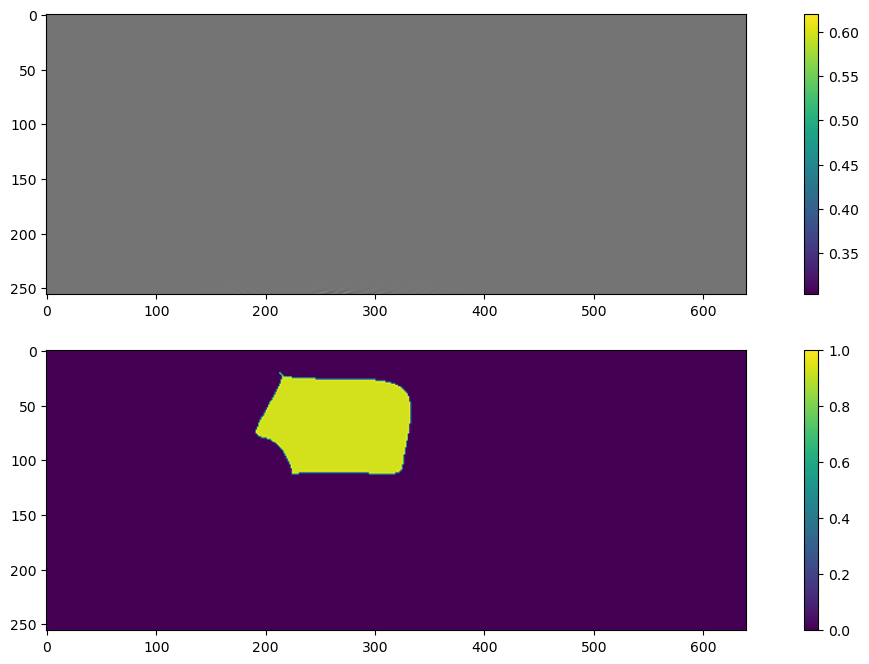

In [11]:
random_idx = random.randint(0, len(val_dataset) - 1)
image, target = train_dataset[random_idx]

image_np = tensor_to_image(image.squeeze(0))[:,:,:]   # Оригинальное изображение
target_np = tensor_to_image(target.squeeze(0))[:,:,0] # Оригинальный таргет

# Рисуем результат
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)

plt.imshow(image_np)
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(target_np)
plt.colorbar()

In [12]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight_factor=2.0, reduction='mean'):
        super(WeightedMSELoss, self).__init__()
        self.weight_factor = weight_factor
        self.reduction = reduction

    def forward(self, pred, target):
        # Вычисляем стандартный MSE
        loss = (pred - target) ** 2
        
        # Применяем взвешивание для пикселей, где target > 0.5
        weight = torch.where(target > 0.8, self.weight_factor, 1.0)
        loss = loss * weight
        
        # Применяем редукцию (по аналогии с MSELoss)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise ValueError("Invalid reduction type. Choose from 'mean', 'sum', or 'none'.")

In [ ]:
model = UNet_girafe(num_classes=3).to(device)
if CFG.USE_MULTIGPU and torch.cuda.device_count() > 1:
    print("Используем несколько GPU")
    model = nn.DataParallel(model)

Используем несколько GPU


In [15]:
criterion = nn.MSELoss()
#criterion = WeightedMSELoss(weight_factor=1.35, reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)

train_model(train_loader, val_loader, model, criterion, optimizer, device)

training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.1706


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1599


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2/50], Loss: 0.1502


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1431


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3/50], Loss: 0.1370


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1323


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4/50], Loss: 0.1270


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1237


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5/50], Loss: 0.1180


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1131


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6/50], Loss: 0.1058


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1004


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7/50], Loss: 0.0965


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0936


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8/50], Loss: 0.0902


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0889


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9/50], Loss: 0.0851


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0831


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.0802


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0786


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [11/50], Loss: 0.0762


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0744


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [12/50], Loss: 0.0721


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0712


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [13/50], Loss: 0.0687


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0672


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [14/50], Loss: 0.0652


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0645


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [15/50], Loss: 0.0628


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0617


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [16/50], Loss: 0.0601


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0588


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [17/50], Loss: 0.0570


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0557


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [18/50], Loss: 0.0544


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0535


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [19/50], Loss: 0.0520


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0510


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [20/50], Loss: 0.0500


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0511


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [21/50], Loss: 0.0475


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0474


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [22/50], Loss: 0.0450


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0458


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [23/50], Loss: 0.0435


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0441


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [24/50], Loss: 0.0415


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0423


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [25/50], Loss: 0.0398


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0422


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [26/50], Loss: 0.0379


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0417


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [27/50], Loss: 0.0368


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0409


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [28/50], Loss: 0.0356


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0394


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [29/50], Loss: 0.0339


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0411


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [30/50], Loss: 0.0333


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0378


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [31/50], Loss: 0.0318


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0369


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [32/50], Loss: 0.0305


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0361


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [33/50], Loss: 0.0292


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0355


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [34/50], Loss: 0.0283


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0350


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [35/50], Loss: 0.0278


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0353


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [36/50], Loss: 0.0270


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0358


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [37/50], Loss: 0.0261


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0347


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [38/50], Loss: 0.0265


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0344


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [39/50], Loss: 0.0260


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0352


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [40/50], Loss: 0.0246


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0328


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [41/50], Loss: 0.0238


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0338


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [42/50], Loss: 0.0228


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0342


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [43/50], Loss: 0.0221


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0331


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [44/50], Loss: 0.0213


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0328


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [45/50], Loss: 0.0210


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0327


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [46/50], Loss: 0.0203


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0324


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [47/50], Loss: 0.0196


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0328


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [48/50], Loss: 0.0190


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0326


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [49/50], Loss: 0.0184


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0323


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [50/50], Loss: 0.0179


validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.0320


In [16]:
# best_model_path = "./models/best_model.pth"

# model = UNet()
# model = nn.DataParallel(model)

# model.load_state_dict(torch.load("models/best_model.pth"))
# model.to(device)

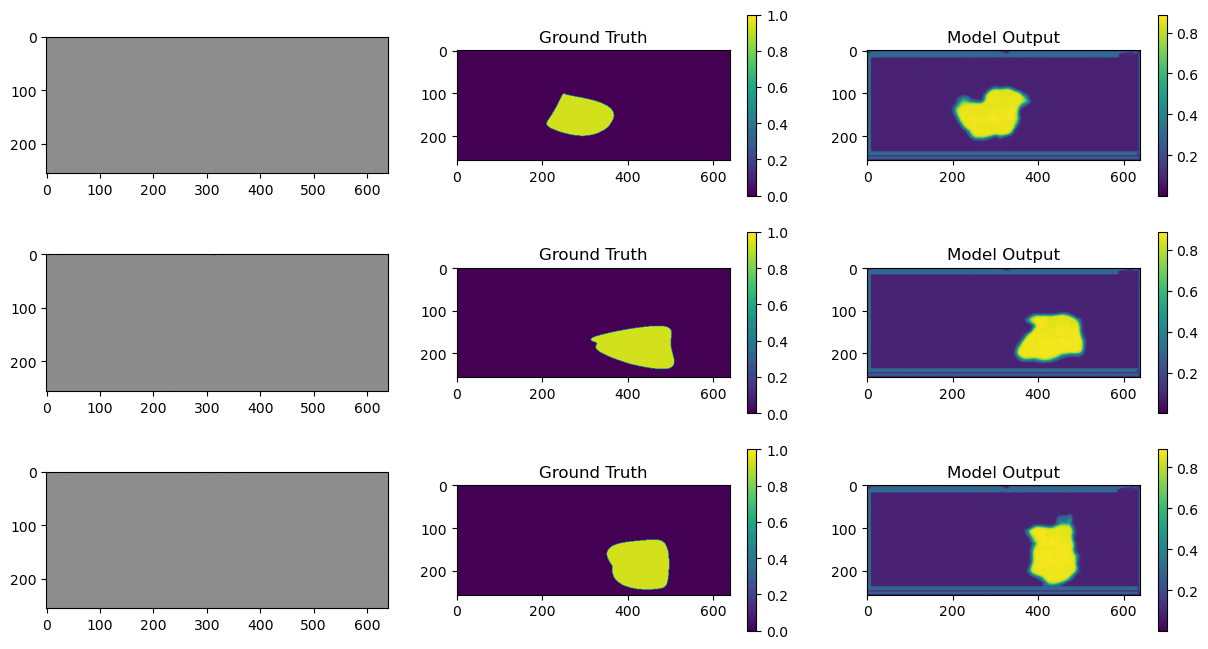

In [17]:
plt.figure(figsize=(15, 8))
for i in range(3):
    random_idx = random.randint(0, len(val_dataset) - 1)

    image, target = val_dataset[random_idx]
    image, target = image.unsqueeze(0).to(device).to(dtype=torch.float32), target.unsqueeze(0).to(device).to(dtype=torch.float32)  # Добавляем batch dim

    model.eval()
    with torch.no_grad():
        output = model(image)

    image_np = tensor_to_image(image.squeeze(0))[:,:,:]   # Оригинальное изображение
    target_np = tensor_to_image(target.squeeze(0))[:,:,:] # Оригинальный таргет
    output_np = tensor_to_image(output.squeeze(0))[:,:,:] # Предсказание модели

    # Рисуем результат
    
    plt.subplot(3, 3, 1+3*(i))
    plt.imshow(image_np)
    #show_seism_log_RGB(image_np)
    plt.subplot(3, 3, 2+3*(i))
    plt.imshow(target_np[:,:,0])
    plt.colorbar()
    plt.title("Ground Truth")
    plt.subplot(3, 3, 3+3*(i))
    plt.imshow(output_np[:,:,0])
    plt.colorbar()
    plt.title("Model Output")
plt.show()